# Finding the nearest objects to the camera

## Install dependencies

In [1]:
!source .venv/bin/activate
!pip3 install -r requirements.txt

  Using cached aiofiles-23.2.1-py3-none-any.whl (15 kB)
  Using cached altair-5.3.0-py3-none-any.whl (857 kB)
  Using cached annotated_types-0.6.0-py3-none-any.whl (12 kB)
  Using cached anyio-4.3.0-py3-none-any.whl (85 kB)
  Using cached attrs-23.2.0-py3-none-any.whl (60 kB)
  Using cached certifi-2024.2.2-py3-none-any.whl (163 kB)
  Using cached charset_normalizer-3.3.2-cp310-cp310-macosx_11_0_arm64.whl (120 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached contourpy-1.2.1-cp310-cp310-macosx_11_0_arm64.whl (244 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fastapi-0.110.2-py3-none-any.whl (91 kB)
  Using cached ffmpy-0.3.2.tar.gz (5.5 kB)
  Preparing metadata (setup.py) ... done
  Using cached filelock-3.13.4-py3-none-any.whl (11 kB)
  Using cached fonttools-4.51.0-cp310-cp310-macosx_10_9_universal2.whl (2.8 MB)
  Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
  Using cached gradio-4.28.0-py3-none-any.whl (12.2 MB)
  Using cach

## Detect segments using YOLOv8


0: 448x640 1 cat, 1 dog, 202.2ms
Speed: 6.6ms preprocess, 202.2ms inference, 13.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/segment/predict


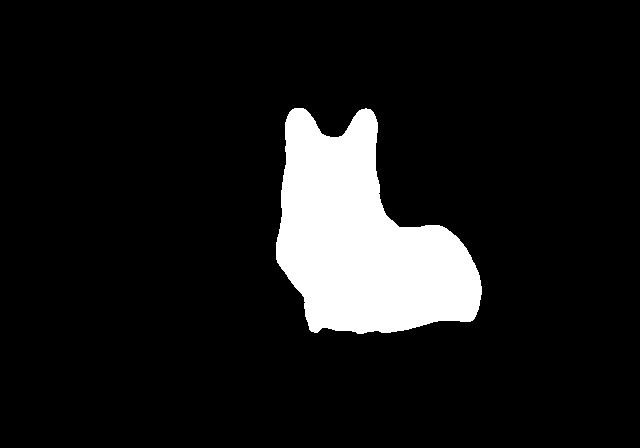

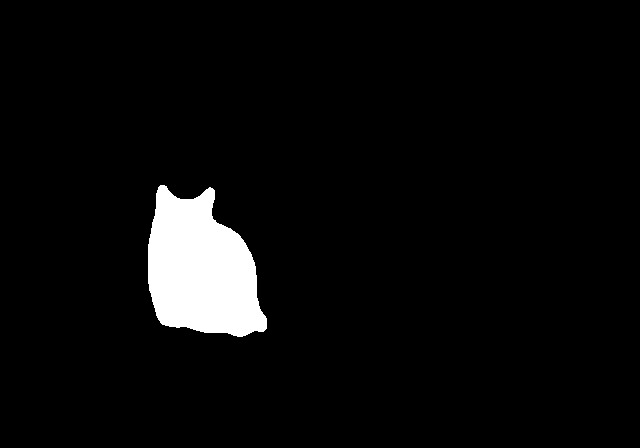

In [32]:
from ultralytics import YOLO
from PIL import Image as PILImage
from IPython.display import display
import cv2


img = cv2.imread('animals.jpg')
model = YOLO('yolov8s-seg.pt')
seg_results = model.predict(img, save=True)

for i, result in enumerate(seg_results):
  for mask in result.masks:
    m = mask.data[0].numpy()
    polygon = mask.xy[0]

    mask_img = PILImage.fromarray(m, mode='I')

    display(mask_img)

## Get a depth heatmap using the Depth-Anything model

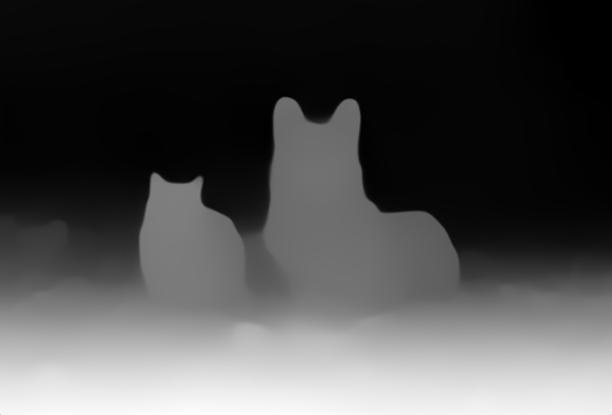

In [39]:
from transformers import pipeline


pipe = pipeline(task='depth-estimation', model='LiheYoung/depth-anything-small-hf')
depth_result = pipe('animals.jpg')

display(depth_result['depth'])

## Evaluate the order of objects nearest to the camera

- Use the masks to index into the `depth_result`
- Rank the segments with the brightest pixels

## Alternative steps

- Using the segment binary_masks, crop out the objects from the heatmap
- Loop through the crops and rank the brightest images

## Alternative steps implementation

https://docs.ultralytics.com/guides/isolating-segmentation-objects/#isolate-with-black-pixels-sub-options

In [48]:
from pathlib import Path

import cv2
import numpy as np
from ultralytics import YOLO
from transformers import pipeline


image = cv2.imread('box.jpg')
model = YOLO('yolov8s-seg.pt')
seg_results = model.predict(image)

pipe = pipeline(task='depth-estimation', model='LiheYoung/depth-anything-small-hf')
depth_result = pipe('box.jpg')
depth_img = depth_result['depth']

cv_img = cv2.cvtColor(np.array(depth_img), cv2.COLOR_RGB2BGR)

resized_cv_img = cv2.resize(cv_img, dsize=(image.shape[1], image.shape[0]))

ranking = []

# iterate detection results 
for result in seg_results:
    img = np.copy(resized_cv_img)
    img_name = Path(result.path).stem

    # iterate each object contour 
    for ci, c in enumerate(result):
        label = c.names[c.boxes.cls.tolist().pop()]

        binary_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(binary_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        # Choose one:

        # OPTION-1: Isolate object with black background
        mask3ch = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
        # print(mask3ch.size, img.size)
        isolated = cv2.bitwise_and(mask3ch, img)

        # OPTION-2: Isolate object with transparent background (when saved as PNG)
        # isolated = np.dstack([img, binary_mask])

        # OPTIONAL: detection crop (from either OPT1 or OPT2)
        x1, y1, x2, y2 = c.boxes.xyxy.cpu().numpy().squeeze().astype(np.int32)
        iso_crop = isolated[y1:y2, x1:x2]

        # TODO your actions go here
        cv2.imwrite(f'{img_name}_{ci}_{label}.png', iso_crop)

        # Rank the objects by brightest found pixel
        ranking.append((label, np.max(iso_crop)))

# Sort by brightness

ranking.sort(key=lambda x: x[1], reverse=True)

print(ranking)


0: 384x640 2 bottles, 1 refrigerator, 151.0ms
Speed: 1.9ms preprocess, 151.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
[('refrigerator', 250), ('bottle', 144), ('bottle', 130)]
